In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [85]:
dataset = pd.read_csv('../inputFile/modelInput/jlco0000st.csv')
dataset = dataset.drop(columns=['Time','FileName',"Valence"])
dataset.head(5)

,Arousal,RMS(dB),F0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5
0,0.00,-71.713486,270.898251,-699.80646,28.912216,25.352512,21.115572,15.291195
1,0.00,-35.781930,189.933902,-589.86100,137.286930,56.127340,16.534332,15.156424
2,0.75,-34.623253,271.101014,-428.87006,161.527480,-5.255958,13.078750,-34.103554
3,0.85,-32.723373,288.888249,-401.31445,156.727330,-59.630970,-37.159626,-42.873610
4,0.70,-26.622677,265.787166,-314.31980,167.580570,-110.440020,-22.299570,-49.224373


In [86]:
# prepare data for lstms
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = pd.read_csv('../inputFile/modelInput/jlco0000st.csv', header=0, index_col=0)
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_steps = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps, 1)
print(reframed.shape)

(6705, 32)


In [87]:
# split into train and test sets
values = reframed.values
n_train_steps = 5360 #80% of dataset
x_
train = values[:n_train_steps, :]
test = values[n_train_steps:, :]

In [88]:
# split into input and outputs
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(5360, 24) 5360 (5360,)


In [89]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5360, 3, 8) (5360,) (1345, 3, 8) (1345,)


Epoch 1/50
75/75 - 3s - loss: 0.2076 - val_loss: 0.1210
Epoch 2/50
75/75 - 1s - loss: 0.1225 - val_loss: 0.0938
Epoch 3/50
75/75 - 1s - loss: 0.1094 - val_loss: 0.0987
Epoch 4/50
75/75 - 1s - loss: 0.1024 - val_loss: 0.0858
Epoch 5/50
75/75 - 0s - loss: 0.1043 - val_loss: 0.0953
Epoch 6/50
75/75 - 0s - loss: 0.1035 - val_loss: 0.0846
Epoch 7/50
75/75 - 0s - loss: 0.0941 - val_loss: 0.0817
Epoch 8/50
75/75 - 1s - loss: 0.0954 - val_loss: 0.0863
Epoch 9/50
75/75 - 1s - loss: 0.0930 - val_loss: 0.0756
Epoch 10/50
75/75 - 1s - loss: 0.0871 - val_loss: 0.0773
Epoch 11/50
75/75 - 0s - loss: 0.0896 - val_loss: 0.0716
Epoch 12/50
75/75 - 1s - loss: 0.0891 - val_loss: 0.0747
Epoch 13/50
75/75 - 0s - loss: 0.0849 - val_loss: 0.0685
Epoch 14/50
75/75 - 0s - loss: 0.0786 - val_loss: 0.0743
Epoch 15/50
75/75 - 0s - loss: 0.0801 - val_loss: 0.0673
Epoch 16/50
75/75 - 0s - loss: 0.0816 - val_loss: 0.0619
Epoch 17/50
75/75 - 0s - loss: 0.0720 - val_loss: 0.0572
Epoch 18/50
75/75 - 0s - loss: 0.0666 - 

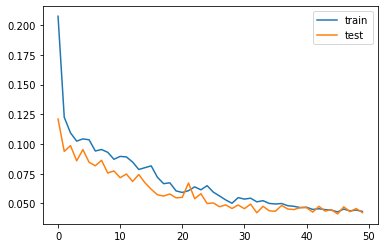

In [90]:
# design network
model = keras.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [91]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_steps*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.129


In [95]:
from sklearn.metrics import r2_score
r2_score(inv_y, inv_yhat)

0.8939665104388458

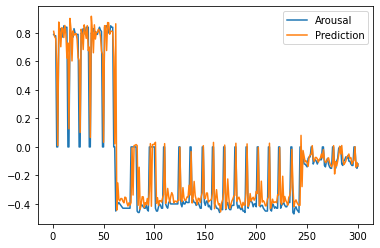

In [92]:
pred_test_list = [i for i in inv_yhat]
submission = pd.DataFrame({'Arousal' : inv_y, 'Prediction' : pred_test_list})
submission.loc[1:, ['Arousal', 'Prediction']][0:300].plot()
submission.to_csv('submission.csv', index=False)

In [93]:
correlation = submission.corr(method='pearson')
print(correlation)

             Arousal  Prediction
Arousal     1.000000    0.948181
Prediction  0.948181    1.000000


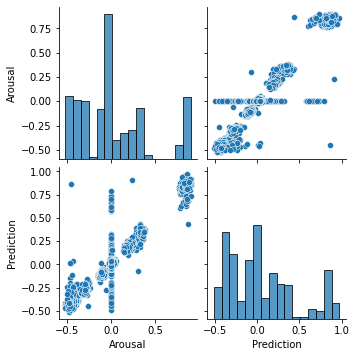

In [94]:
d0 = submission[['Arousal', 'Prediction']]
sns.pairplot(d0, kind="scatter")
plt.show()